In [1]:
import math
import os
import sys
sys.path.insert(0,'../src/')
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
from database import SQLiteDatabase
from experiment import preliminary_setup
import query

In [2]:
KWARGS = preliminary_setup()
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
register_matplotlib_converters()
DB_DIRECTORY = KWARGS['database_directory']
FIGURES_DIRECTORY = KWARGS['figure_directory']
DATABASE = SQLiteDatabase(os.path.join(DB_DIRECTORY,'deployment_strategy_3_1.db'))
FULL_YEAR_SAC_DATABASE = SQLiteDatabase(os.path.join(DB_DIRECTORY,'deployment_strategy_1_1.db'))
RBC_REFERENCE_COST_SUMMARY = pd.read_csv(os.path.join(KWARGS['summary_directory'], 'rbc_reference_3_cost_summary.csv'))
RBC_REFERENCE_LOAD_SUMMARY = pd.read_csv(os.path.join(KWARGS['summary_directory'], 'rbc_reference_3_load_summary.csv'))

cost_labels = {
    'electricity_consumption': r'$D$', 
    'price': r'$C$', 
    'carbon_emission': r'$G$',
    'zero_net_energy': r'$Z$',
    'daily_peak': r'$P$',
    'ramping': r'$R$',
    'load_factor': r'$1 - L$',
}

# Building-Level Scores

In [3]:
building_cost_data = DATABASE.query_table(query.get_building_cost_summary())
full_year_sac_building_cost_data = FULL_YEAR_SAC_DATABASE.query_table(query.get_building_cost_summary())

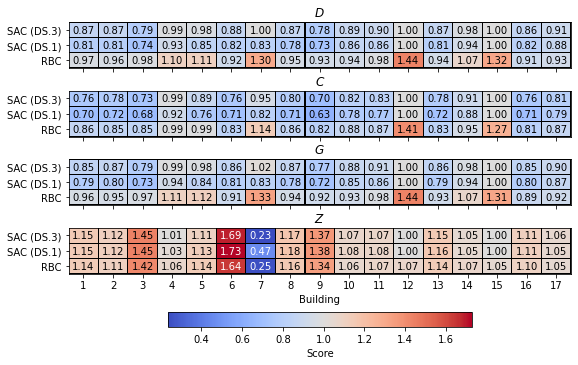

,cost,value
0,carbon_emission,6.014884
1,electricity_consumption,5.824131
2,price,5.600563
3,zero_net_energy,-2.033402


In [60]:
costs = ['electricity_consumption', 'price',  'carbon_emission', 'zero_net_energy']
row_count = len(costs)
column_count = 1
cmap = 'coolwarm'
plot_data = building_cost_data[(building_cost_data['episode']==building_cost_data['episode'].max())].copy()
plot_data['agent'] = 'SAC (DS.3)'
rbc_plot_data = RBC_REFERENCE_COST_SUMMARY.query('scope == "building"').copy()
rbc_plot_data['agent'] = 'RBC'
full_year_sac_plot_data = full_year_sac_building_cost_data[building_cost_data['episode']==building_cost_data['episode'].max()].copy()
full_year_sac_plot_data['agent'] = 'SAC (DS.1)'
plot_data = pd.concat([plot_data, rbc_plot_data, full_year_sac_plot_data], ignore_index=True, sort=False)
plot_data = plot_data[(plot_data['cost'].isin(costs))].copy()
vcenter = 1.0
vmin = plot_data['value'].min()
vmax = plot_data['value'].max()
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
fig, axs = plt.subplots(row_count, column_count, figsize=(9*column_count,1.4*row_count), sharex=True, gridspec_kw={'hspace':0.5})

for i, ax in enumerate(fig.axes):
    c_data = plot_data[plot_data['cost']==costs[i]].copy()
    c_data = c_data.pivot(index='agent', columns='building_id', values='value')
    x, y, z = c_data.columns.astype(int).astype(str), c_data.index, c_data.values
    pcm = ax.pcolormesh(x, y, z, shading='nearest', cmap=cmap, norm=divnorm, edgecolors='black', linewidth=0.1)
    
    ax.tick_params('x', which='both', rotation=0)

    if i == row_count - 1:
        ax.set_xlabel('Building')
    else:
        ax.set_xlabel(None)

    ax.set_ylabel(None)
    ax.set_title(cost_labels[costs[i]])

    for (i, j), z in np.ndenumerate(c_data):
        color = 'black' if 0.5 <= z <= 1.5 else 'white'
        ax.text(j,i,f'{z:0.2f}', ha='center', va='center', color=color)

cb = fig.colorbar(pcm, ax=fig.axes, orientation='horizontal', label='Score', fraction=0.05, pad=0.125)

# plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIRECTORY,f'deployment_strategy_3_1_building_cost_summary.pdf'),bbox_inches='tight',transparent=True)
plt.show()

summary_data = plot_data[plot_data['agent']!='RBC'].copy()
summary_data.loc[summary_data['agent']=='SAC (DS.1)', 'value'] *= -1
summary_data = summary_data.groupby(['building_id', 'cost'])[['value']].sum().reset_index()
summary_data = summary_data.groupby(['cost'])[['value']].mean().reset_index()
summary_data['value'] *= 100.0
display(summary_data)

In [5]:
# costs = ['zero_net_energy', 'price', 'electricity_consumption', 'carbon_emission']
# row_count = len(costs)
# column_count = 1
# cmap = 'coolwarm'
# plot_data = building_cost_data[building_cost_data['episode']==building_cost_data['episode'].max()].copy()
# plot_data['agent'] = 'SAC (trained on half year)'
# rbc_plot_data = RBC_REFERENCE_COST_SUMMARY.query('scope == "building"').copy()
# rbc_plot_data['agent'] = 'RBC'
# full_year_sac_plot_data = full_year_sac_building_cost_data[building_cost_data['episode']==building_cost_data['episode'].max()].copy()
# full_year_sac_plot_data['agent'] = 'SAC (trained on full year)'
# plot_data = pd.concat([plot_data, rbc_plot_data, full_year_sac_plot_data], ignore_index=True, sort=False)
# vcenter = 1.0
# vmin = plot_data['value'].min()
# vmax = plot_data['value'].max()
# divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# fig, ax = plt.subplots(row_count, column_count, figsize=(6.0*column_count,2.0*row_count))
# marker_size = 8
# edgecolor = 'black'
# linewidth = 1

# for i, ax in enumerate(fig.axes):
#     c_data = plot_data[plot_data['cost']==costs[i]].copy()
#     sns.barplot(y='value', x='building_id', data=plot_data, hue_order=['RBC', 'SAC (trained on full year)', 'SAC (trained on half year)'], hue='agent', ax=ax, errwidth=0)

#     # sns.stripplot(x='building_id', y='value', data=c_data[c_data['agent']=='RBC'], ax=ax, jitter=False, color='red', clip_on=False, size=marker_size, edgecolor=edgecolor, linewidth=linewidth, marker='^', label='RBC')
#     # sns.stripplot(x='building_id', y='value', data=c_data[c_data['agent']=='SAC (trained on full year)'], ax=ax, jitter=False, color='green', clip_on=False, size=marker_size*0.8, edgecolor=edgecolor, linewidth=linewidth, marker='o', label='SAC (trained on full year)')
#     # sns.stripplot(x='building_id', y='value', data=c_data[c_data['agent']=='SAC (trained on half year)'], ax=ax, jitter=False, color='blue', clip_on=False, size=marker_size*0.8, edgecolor=edgecolor, linewidth=linewidth, marker='D', label='SAC (trained on half year)')
#     # ax.axhline(1.0, color='black', linestyle='--', label='Baseline (no battery)')
#     building_ids = sorted(c_data[f'building_id'].astype(int).unique().tolist())
#     ax.xaxis.set_major_locator(ticker.FixedLocator([i - 1 for i in building_ids]))
#     ax.set_xticklabels(building_ids)
#     ax.set_xlabel('Building')
#     ax.set_ylabel(None)
#     ax.set_title(costs[i])

#     for s in ['right','top']:
#         ax.spines[s].set_visible(False)

#     if i == row_count - 1:
#         handles, labels = ax.get_legend_handles_labels()
#         unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
#         ax.legend(bbox_to_anchor=(0.5, -0.35), loc='upper center', framealpha=0, ncol=2, *zip(*unique))
#     else:
#         ax.legend().set_visible(False)

# plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIRECTORY,f'deployment_strategy_3_1_building_cost_summary.pdf'),bbox_inches='tight',transparent=True)
# plt.show()

# summary_data = plot_data[plot_data['agent']!='RBC'].copy()
# summary_data.loc[summary_data['agent']=='SAC (trained on full year)', 'value'] *= -1
# summary_data = summary_data.groupby(['building_id', 'cost'])[['value']].sum().reset_index()
# summary_data = summary_data.groupby(['cost'])[['value']].mean().reset_index()
# summary_data['value'] *= 100.0
# display(summary_data)

# District-Level Scores

In [6]:
district_cost_data = DATABASE.query_table(query.get_district_cost_summary())
full_year_sac_district_cost_data = FULL_YEAR_SAC_DATABASE.query_table(query.get_district_cost_summary())

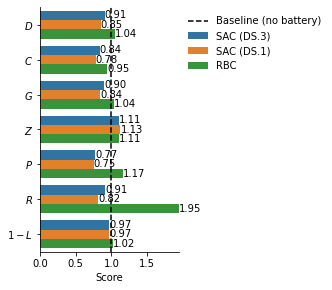

In [7]:
row_count = 1
column_count = 1
fig, ax = plt.subplots(row_count, column_count, figsize=(column_count*2.5, row_count*4.5))
plot_data = district_cost_data[district_cost_data['episode']==district_cost_data['episode'].max()].copy()
plot_data['agent'] = 'SAC (DS.3)'
full_year_sac_plot_data = full_year_sac_district_cost_data[district_cost_data['episode']==district_cost_data['episode'].max()].copy()
full_year_sac_plot_data['agent'] = 'SAC (DS.1)'
rbc_plot_data = RBC_REFERENCE_COST_SUMMARY.query('scope == "district"').copy()
rbc_plot_data['agent'] = 'RBC'
plot_data = pd.concat([plot_data, rbc_plot_data, full_year_sac_plot_data], ignore_index=True, sort=False)
plot_data['cost_label'] = plot_data['cost'].map(lambda x: cost_labels[x])
hue_order = ['SAC (DS.3)', 'SAC (DS.1)', 'RBC']
sns.barplot(x='value', y='cost_label', data=plot_data, hue='agent', order=cost_labels.values(), hue_order=hue_order, ax=ax)
ax.axvline(1.0, color='black', linestyle='--', label='Baseline (no battery)')
ax.set_xlabel('Score')
ax.set_ylabel(None)

for s in ['right','top']:
    ax.spines[s].set_visible(False)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width(), p.get_y() + p.get_height()/2.0, f'{p.get_width():0.2f}', ha='left', va='center')

ax.legend(
    bbox_to_anchor=(1.0,1.0),
    loc='upper left',
    framealpha=0,
    ncol=1
)

plt.savefig(os.path.join(FIGURES_DIRECTORY,f'deployment_strategy_3_1_district_cost_summary.pdf'),bbox_inches='tight',transparent=True)
plt.show()

# Building-Level Average Daily Profile

In [8]:
building_load_data = DATABASE.query_table(query.get_building_average_daily_profile())

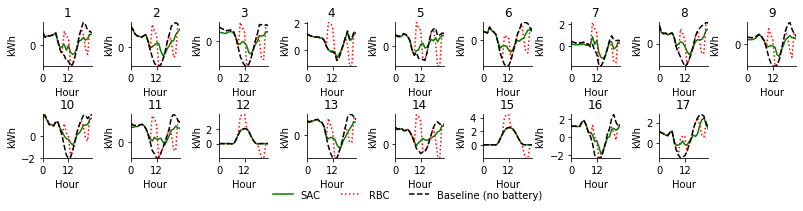

In [9]:
plot_data = building_load_data[building_load_data['episode']==building_load_data['episode'].max()].copy()
rbc_plot_data = RBC_REFERENCE_LOAD_SUMMARY[RBC_REFERENCE_LOAD_SUMMARY['scope']=='building'][[
    'building_id', 'hour', 'with_storage_value'
]].copy()
rbc_plot_data = rbc_plot_data.rename(columns={'with_storage_value': 'rbc_with_storage_value'})
plot_data = plot_data.merge(rbc_plot_data, on=['hour', 'building_id'], how='inner')
column_count_limit = 9
building_id_count = len(plot_data['building_id'].unique())
row_count, column_count = math.ceil(building_id_count/column_count_limit), min(column_count_limit, building_id_count)
fig, _ = plt.subplots(row_count, column_count, figsize=(1.5*column_count, 1.25*row_count), gridspec_kw={'wspace':0.8, 'hspace':1.1})

for ax in fig.axes[int(row_count*column_count - 1):]:
    ax.set_visible(False)

for i, (ax, (b, b_data)) in enumerate(zip(fig.axes, plot_data.groupby(['building_id']))):
    x, y1, y2, y3 = b_data['hour'], b_data['with_storage_value'], b_data['rbc_with_storage_value'], b_data['without_storage_value']
    ax.plot(x, y1, color='green', label='SAC')
    ax.plot(x, y2, color='red', label='RBC', linestyle=':',)
    ax.plot(x, y3, color='black', linestyle='--', label='Baseline (no battery)')
    ax.set_title(b)
    ax.set_xlabel('Hour')
    ax.set_ylabel('kWh')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(12))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

    if i == 0:
        ax.legend(
            bbox_to_anchor=(0.5,0),
            loc='upper center', 
            bbox_transform=fig.transFigure,
            framealpha=0,
            ncol=3
        )
    else:
        ax.legend().set_visible(False)

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

fig.align_ylabels()
# plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIRECTORY,f'deployment_strategy_3_1_building_average_daily_load_profile.pdf'),bbox_inches='tight',transparent=True)
plt.show()

# Save

In [10]:
building_cost_data['scope'] = 'building'
district_cost_data['scope']= 'district'
pd.concat([building_cost_data, district_cost_data], ignore_index=True, sort=False).to_csv(
    os.path.join(KWARGS['summary_directory'], 'deployment_strategy_3_1_cost_summary.csv'), index=False
)